In [2]:
import os

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "`0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [4]:
import numpyro
import jax.numpy as jnp
import equinox as eqx
from copy import deepcopy
from math import prod
from jax import random, nn, vmap, devices, device_put

from bmr4pml.models import SVIRegression, BMRRegression
from bmr4pml.nn import MLP, LeNet, resnet18, resnet34, resnet50, mish
from bmr4pml.datasets import load_data
from bmr4pml.inference import fit_and_test

from optim import vadam, vadabelief

rng_key = random.PRNGKey(0)

In [5]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def run_inference(rng_key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression):

    reg = reg_model(
        nnet,
        **opts_regression
    )

    rng_key, opts_fitting['key'] = random.split(rng_key)
    return fit_and_test(reg, train_ds, test_ds, opts_fitting)

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.7, 1.])
    fig.tight_layout()

    return fig

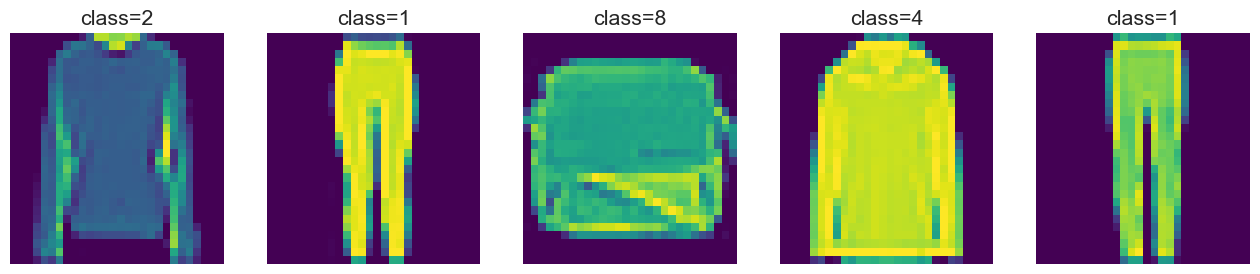

In [6]:
# load data
train_ds, test_ds = load_data('fashion_mnist', platform='gpu', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)

# DenseNet

In [7]:
depth = 4
num_neurons = 500
num_epochs = 5
num_iters = 80_000

In [8]:
train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

(1, 32, 32)


In [9]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.05,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
# nnet = MLP( prod(in_size), out_size, num_neurons, depth, activation=nn.swish, dropout_rate=0.0, key=key)
nnet = LeNet(in_size, activation=nn.tanh, dropout_rate=0.0, key=key)

In [10]:
import jax.tree_util as jtu
import numpyro.distributions as dist

def init_fn(rng_key, shape, radius=2.):
    return random.uniform(rng_key, shape=shape, minval=-radius, maxval=radius)

def get_linear_layers(nnet):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear) or isinstance(x, eqx.nn.Conv) or isinstance(x, eqx.nn.LayerNorm)
    return [x for x in jtu.tree_leaves(nnet, is_leaf=is_linear) if is_linear(x)]

def register_network_params(nnet, mask):
    layers = get_linear_layers(nnet)
    L = len(layers)
    new_layers = []
    for l, layer in enumerate(layers):
        name = f'layer{l}.params'
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)
        
        _weights = numpyro.param(f'layer{l}.params', lambda key: init_fn(rng_key, shape, radius=2.))

        _weights = jnp.where(mask[name], _weights, 0.) if mask is not None else _weights
        
        weight = _weights.reshape(weight.shape) if bias is None else _weights[..., :-1].reshape(weight.shape)
        bias = _weights[..., -1].reshape(bias.shape) if bias is not None else bias

        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    return eqx.tree_at(get_linear_layers, nnet, new_layers)

def likelihood(nnet, x, y, batch_size=None):
    N = x.shape[0]
    with numpyro.plate('data', N, subsample_size=batch_size):
        batch_x = numpyro.subsample(x, event_dim=3)
        key = random.PRNGKey(0) if numpyro.prng_key() is None else numpyro.prng_key()
        keys = random.split(key, batch_x.shape[0]) 
        logits = vmap(nnet)(batch_x, key=keys)

        batch_y = y if y is None else numpyro.subsample(y, event_dim=0)

        with numpyro.handlers.scale(scale=1/N):
            numpyro.sample('obs', dist.Categorical(logits=logits), obs=batch_y)

def model(nnet, x, y=None, batch_size=None, mask=None):

    nnet = register_network_params(nnet, mask)
    likelihood(nnet, x, y, batch_size)

def guide(*args, **kwargs):
    pass

In [ ]:
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.optim import _NumPyroOptim
import optax

class OptaxToNumpyro(object):

    def __init__(self, rng_key, t_lam, N):
        self.rng_key = rng_key
        self.t_lam = t_lam
        self.N = N

    def __call__(self, transformation) -> _NumPyroOptim:
        """
        This function produces a ``numpyro.optim._NumPyroOptim`` instance from an
        ``optax.GradientTransformation`` so that it can be used with
        ``numpyro.infer.svi.SVI``. It is a lightweight wrapper that recreates the
        ``(init_fn, update_fn, get_params_fn)`` interface defined by
        :mod:`jax.example_libraries.optimizers`.

        :param transformation: An ``optax.GradientTransformation`` instance to wrap.
        :return: An instance of ``numpyro.optim._NumPyroOptim`` wrapping the supplied
            Optax optimizer.
        """

        def init_fn(params):
            opt_state = transformation.init(params)
            return params, opt_state

        def update_fn(step, grads, state):
            params, opt_state = state
            updates, opt_state = transformation.update(grads, opt_state, params)
            updated_params = optax.apply_updates(params, updates)
            return updated_params, opt_state

        def get_params_fn(state):
            params, opt_state = state
            scales = jtu.tree_map( lambda x: jnp.sqrt(1/(N * (x + t_lam))), opt_state[0].s)
            keys = {}
            for name in scales:
                self.rng_key, keys[name] = random.split(rng_key)
            noise = jtu.tree_map( lambda x, key: x * random.normal(key, shape=x.shape), scales, keys )
            theta = jtu.tree_map(lambda x, e: x + e, params, noise)

            return theta

        return _NumPyroOptim(lambda x, y, z: (x, y, z), init_fn, update_fn, get_params_fn)

N = 60_000
t_lam = 10 / N
t_init = 100 / N
learning_rate = 1e-2
loss = Trace_ELBO()

rng_key, key = random.split(rng_key)
_optax_to_numpyro = OptaxToNumpyro(key, t_lam, N)
optimizer1 = _optax_to_numpyro( vadam(learning_rate=learning_rate, t_lam=t_lam, t_init=t_init) )
optimizer2 = _optax_to_numpyro( vadabelief(learning_rate=learning_rate, t_lam=t_lam, t_init=t_init) )

In [ ]:
from numpyro.optim import optax_to_numpyro
optimizer3 = optax_to_numpyro( optax.adabelief(learning_rate=learning_rate) )

In [ ]:
def del_f(mu, scale):
    return - (2 * jnp.log(scale) + mu ** 2 / scale ** 2) / 2

100%|██████████| 20000/20000 [01:04<00:00, 312.44it/s, init loss: 0.7957, avg. loss [19001-20000]: 0.1926]


{'layer0.params': Array(0.32051283, dtype=float32), 'layer1.params': Array(0.86713576, dtype=float32), 'layer2.params': Array(0.9197423, dtype=float32), 'layer3.params': Array(0.92099565, dtype=float32), 'layer4.params': Array(0.89176464, dtype=float32)}


100%|██████████| 20000/20000 [01:04<00:00, 312.22it/s, init loss: 0.7101, avg. loss [19001-20000]: 0.1891]


{'layer0.params': Array(0.37820512, dtype=float32), 'layer1.params': Array(0.85844374, dtype=float32), 'layer2.params': Array(0.9224646, dtype=float32), 'layer3.params': Array(0.9230618, dtype=float32), 'layer4.params': Array(0.8623529, dtype=float32)}


100%|██████████| 20000/20000 [01:03<00:00, 313.57it/s, init loss: 0.3135, avg. loss [19001-20000]: 0.3038]


{'layer0.params': Array(-2., dtype=float32), 'layer1.params': Array(-2., dtype=float32), 'layer2.params': Array(-2., dtype=float32), 'layer3.params': Array(-2., dtype=float32), 'layer4.params': Array(-2., dtype=float32)}


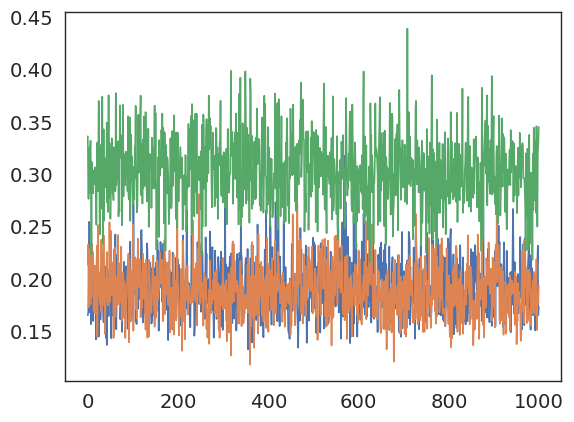

In [ ]:
batch_size = 512
num_iters = 20_000
args = (nnet, train_ds['image'])
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size
}
mus = []
sigmas = []
for optim in [optimizer1, optimizer2, optimizer3]:
    svi = SVI(model, guide, optim, loss)
    rng_key, key = random.split(rng_key)
    state = svi.init(key, *args, **kwargs)
    params = svi.get_params(state)
    mask = jtu.tree_map(lambda x: True, params)

    for i in range(3):
        key, _key = random.split(key)
        results = svi.run(
            _key, 
            num_iters,
            *args,
            progress_bar=True,
            init_state=state,
            init_params=params,
            ** kwargs | {'mask': mask}
        )

        state = results.state
        params = results.params
        try:
            scales = jtu.tree_map( lambda x: 1 / jnp.sqrt( N * (x + t_lam) ), state.optim_state[1][1][0].s)
            mu = params
            if i < 2:
                mask = jtu.tree_map(lambda m, s, t: t * (del_f(m, s) <= 0), mu, scales, mask)
        except:
            pass

    try:
        pruned_fraction = jtu.tree_map( lambda m: jnp.mean(~m), mask)
        print(pruned_fraction)
    except:
        pass

    losses = results.losses
    try:
        scales = jtu.tree_map( lambda x: 1 / jnp.sqrt( N * (x + t_lam) ), state.optim_state[1][1][0].s)
        mus.append( jtu.tree_map( lambda t, p: t*p, mask, params) )
        sigmas.append( jtu.tree_map( lambda t, p: t*p, mask, scales) )
    except:
        mus.append(params)

    plt.plot(losses[-1000:])

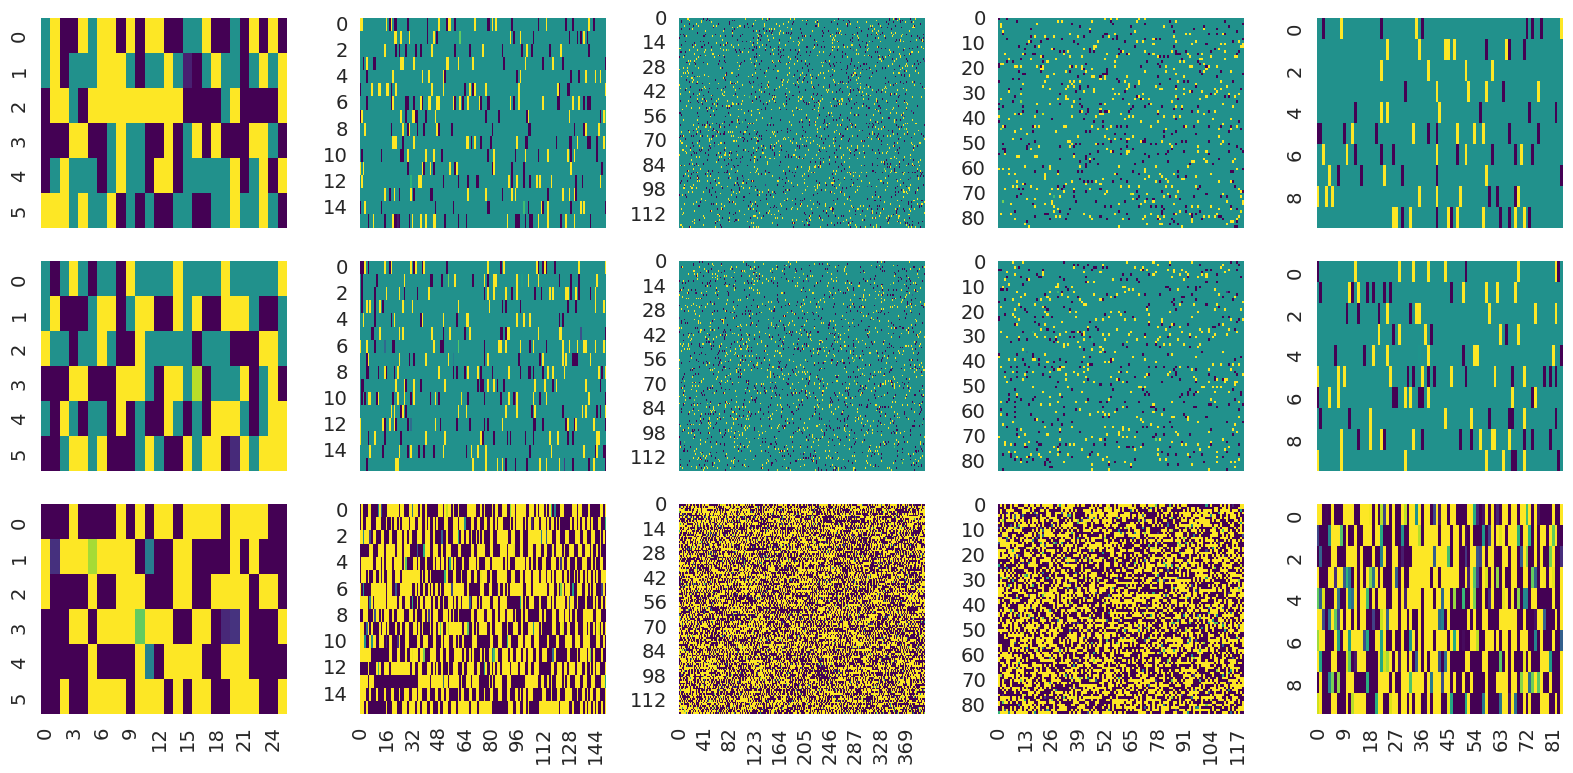

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex='col')

for i, key in enumerate(mus[0]):
    sns.heatmap( mus[0][key], ax = axes[0, i], cmap='viridis', cbar=False, vmax=.1, vmin=-.1)

for i, key in enumerate(mus[1]):
    sns.heatmap( mus[1][key], ax = axes[1, i], cmap='viridis', cbar=False, vmax=.1, vmin=-.1 )

for i, key in enumerate(mus[2]):
    sns.heatmap( mus[2][key], ax = axes[2, i], cmap='viridis', cbar=False, vmax=.1, vmin=-.1 )

fig.tight_layout()

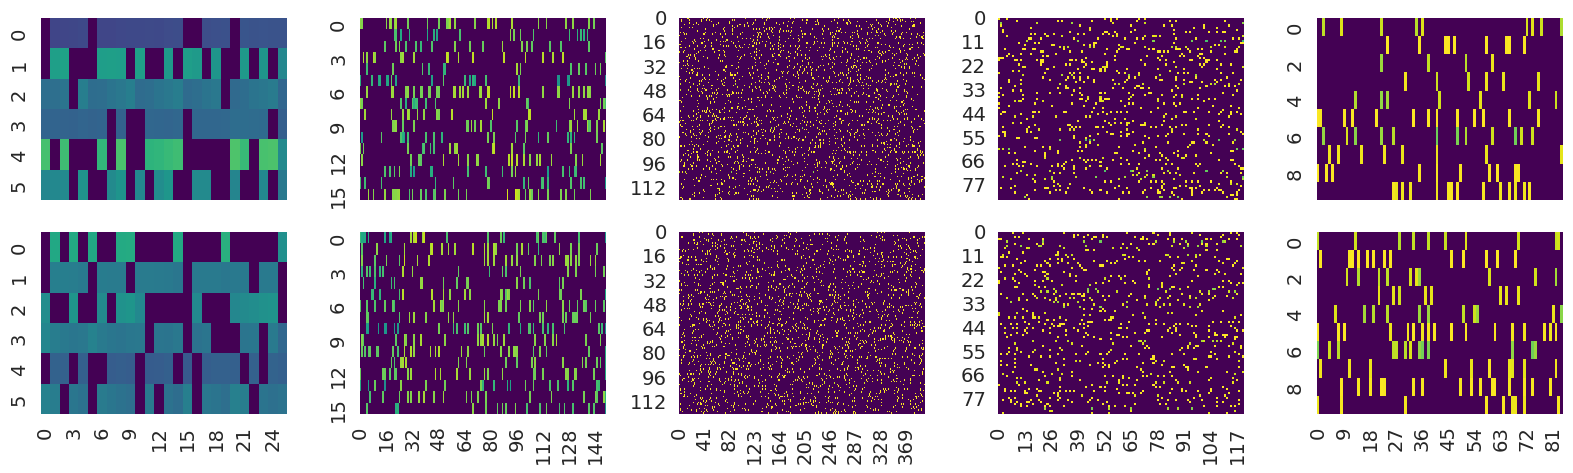

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(16, 5), sharex='col')

for i, key in enumerate(sigmas[0]):
    sns.heatmap( sigmas[0][key], ax = axes[0, i], cmap='viridis', cbar=False, vmax=jnp.sqrt(1/10), vmin=0.)

for i, key in enumerate(sigmas[1]):
    sns.heatmap( sigmas[1][key], ax = axes[1, i], cmap='viridis', cbar=False, vmax=jnp.sqrt(1/10), vmin=0. )

fig.tight_layout()

# CIFAR10

(3, 36, 36) 10


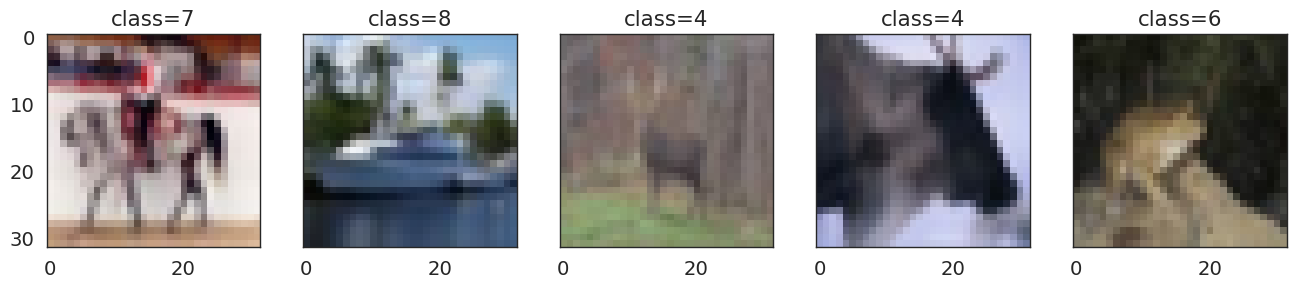

In [ ]:
# load data
cif10_train_ds, cif10_test_ds = load_data('cifar10', platform='gpu', id=0)

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif10_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif10_train_ds['label'][n]))

cif10_train_ds['image'], cif10_test_ds['image'] = standardize(cif10_train_ds['image'], cif10_test_ds['image'], num_channels=3)

cif10_train_ds['image'] = jnp.pad(cif10_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif10_test_ds['image'] = jnp.pad(cif10_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif10 = cif10_train_ds['image'].shape[-3:]
out_size_cif10 = len(jnp.unique(cif10_train_ds['label']))

print(in_size_cif10, out_size_cif10)

# CIFAR100

(3, 36, 36) 100


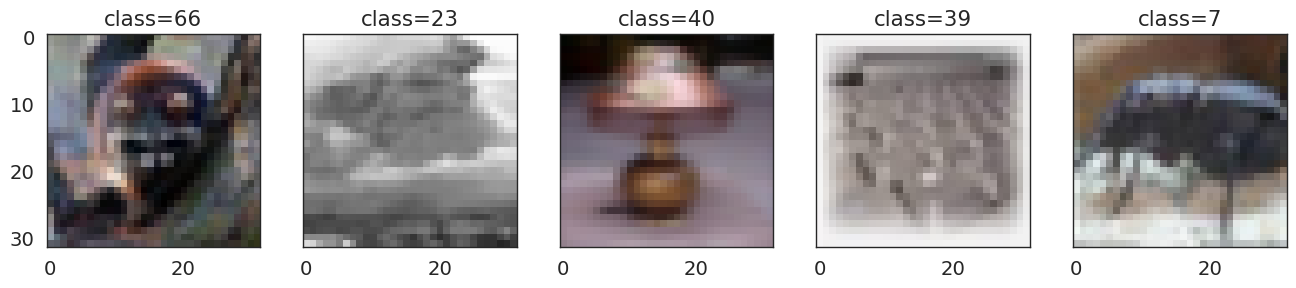

In [ ]:
# load data
cif100_train_ds, cif100_test_ds = load_data('cifar100', platform='gpu', id=0)

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif100_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif100_train_ds['label'][n]))

cif100_train_ds['image'], cif100_test_ds['image'] = standardize(cif100_train_ds['image'], cif100_test_ds['image'], num_channels=3)

cif100_train_ds['image'] = jnp.pad(cif100_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif100_test_ds['image'] = jnp.pad(cif100_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

print(in_size_cif100, out_size_cif100)

Lie-group BLR diagonal affine group

$$ q_0 = \mathcal{N}(0, 1) $$
$$ c_X = \int \left( 1 + x \frac{q_0^\prime(x)}{q_0(x)} \right)^2 q_0(x) d x  = \int \left( 1 - x^2  \right)^2 q_0(x) d x  = 2$$

$$ c_y = \int \frac{q_0^\prime(x)^2}{q_0(x)} dx = \int  x^2 q_0(x) d x = 1$$

Loss function $ l(\pmb{\theta})= \sum_{i=1}^N l_i(\theta) + R(\theta) $, where first term corresponds to the log-likelihood and the second term the log-prior.
We will consider the case where the loss is approximatly estimated from mini-batches $\mathcal{J}$ of size $n$ as 

$$ \hat{l}(\pmb{\theta})= \frac{N}{n}\sum_{i \in \mathcal{J}} l_i(\theta) + R(\theta) $$

Initialize $(A, b) \in \mathbb{R}_{>0}^P \times \mathbb{R}^P$ randomly, and $M_U = M_V = 0 \in \mathbb{R}^P$:

* while not converged do
  * Sample a minibatch $J \subseteq [1\ldots N]$ of size n,
  * Sample noise vectors $\epsilon_k \sim q_0$ for $k = 1, \ldots, K$,
  * Set $\theta_k = A \cdot \epsilon_k + b$, the MC-parameter samples,
  * $U_k = A \epsilon_k \frac{1}{N} \nabla \hat{l}(\theta_k) - \frac{\tau}{N} \bf{1}$,
  * $ U = \frac{1}{c_X K}\sum_{k=1}^K U_k $,
  * $V_k = A \frac{1}{N} \nabla \hat{l}(\theta_k)$,
  * $ V = \frac{1}{c_y K} \sum_{k=1}^K V_k $,
  * $M_V = (1 - \beta_2) V + \beta_2 M_V$,
  * $M_U = (1 - \beta_1) U + \beta_1 M_U$,
  * $ b = b + A \frac{\exp(-\alpha M_U) - I}{M_U} M_V $,
  * $ A = A \exp( - \alpha M_U) $.

For numerical stability we divide the moment by the number of data-points $N$.